## Agent-Based SEIR Model

In [21]:
import numpy as np 
import matplotlib.pyplot as plt 
from typing import Optional, Dict, List

## Building Agent Class

In [22]:
#==============
# Agent Class
#==============
class Agent:
    """
    Individual agent in spatial SEIR model.
    
    Attributes:
        id (int): Unique identifier
        x, y (float): Position coordinates
        state (str): Disease state - one of ['S', 'E1', 'E2', 'I1', 'I2', 'R1', 'R2']
        time_in_state (float): Duration in current state (days)
    """
    
    VALID_STATES = {'S', 'E1', 'E2', 'I1', 'I2', 'R1', 'R2'}
    __slots__ = ['id', 'x', 'y', 'state', 'time_in_state']
    
    def __init__(self, id: int, x: float, y: float, 
                 state: str = 'S', time_in_state: float = 0.0):
        if x < 0 or y < 0:
            raise ValueError(f"Coordinates must be non-negative. Got x={x}, y={y}")
        if state not in self.VALID_STATES:
            raise ValueError(f"Invalid state '{state}'. Must be one of {self.VALID_STATES}")
        if time_in_state < 0:
            raise ValueError(f"time_in_state must be non-negative. Got {time_in_state}")
        
        self.id = id
        self.x = x
        self.y = y
        self.state = state
        self.time_in_state = time_in_state
    
    def distance_to(self, other: 'Agent') -> float:
        """Calculate Euclidean distance to another agent."""
        return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
    
    def __repr__(self) -> str:
        return (f"Agent(id={self.id}, pos=({self.x:.1f}, {self.y:.1f}), "
                f"state='{self.state}', t={self.time_in_state:.1f})")
    
    def __str__(self) -> str:
        return f"Agent #{self.id} [{self.state}] at ({self.x:.1f}, {self.y:.1f})"

## Initializing Population 

In [23]:
#============================
# Population Initialization
#============================
def initialize_population(
    n_agents: int,
    space_size: float,
    initial_states: Optional[Dict[str, int]] = None,
    spatial_distribution: str = 'uniform',
    seed: Optional[int] = None
) -> List[Agent]:
    """
    Initialize population of agents in 2D space.
    
    Parameters:
        n_agents: Total number of agents
        space_size: Size of square space [0, space_size] x [0, space_size]
        initial_states: Dict mapping states to counts, e.g., {'S': 9900, 'E1': 50, 'E2': 50}
        spatial_distribution: 'uniform' (only option currently)
        seed: Random seed for reproducibility
    
    Returns:
        List of Agent objects
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Validation
    if n_agents <= 0:
        raise ValueError(f"n_agents must be positive. Got {n_agents}")
    if space_size <= 0:
        raise ValueError(f"space_size must be positive. Got {space_size}")
    
    # Default: all susceptible
    if initial_states is None:
        initial_states = {'S': n_agents}
    
    # Validate state distribution
    total_state_count = sum(initial_states.values())
    if total_state_count != n_agents:
        raise ValueError(
            f"Sum of initial_states ({total_state_count}) must equal n_agents ({n_agents})"
        )
    
    invalid_states = set(initial_states.keys()) - Agent.VALID_STATES
    if invalid_states:
        raise ValueError(
            f"Invalid state names: {invalid_states}. Must be one of {Agent.VALID_STATES}"
        )
    
    if spatial_distribution != 'uniform':
        raise ValueError(f"spatial_distribution must be 'uniform'. Got '{spatial_distribution}'")
    
    # Create state assignments and shuffle
    state_assignments = []
    for state, count in initial_states.items():
        state_assignments.extend([state] * count)
    np.random.shuffle(state_assignments)
    
    # Create agents
    agents = []
    for i in range(n_agents):
        agent = Agent(
            id=i,
            x=np.random.uniform(0, space_size),
            y=np.random.uniform(0, space_size),
            state=state_assignments[i]
        )
        agents.append(agent)
    
    return agents

## Spatial Indexing for Finding Neighbors

In [24]:
#====================================
# Spatial Index for Neighbor Finding
#====================================
class SpatialIndex:
    """
    Grid-based spatial index for efficient neighbor queries.
    
    Attributes:
        space_size (float): Size of square space
        cell_size (float): Size of each grid cell
        n_cells (int): Number of cells per dimension
        grid (dict): Maps (cell_x, cell_y) to list of agents
    """
    
    def __init__(self, space_size: float, cell_size: float):
        if space_size <= 0:
            raise ValueError(f"space_size must be positive. Got {space_size}")
        if cell_size <= 0:
            raise ValueError(f"cell_size must be positive. Got {cell_size}")
        
        self.space_size = space_size
        self.cell_size = cell_size
        self.n_cells = int(np.ceil(space_size / cell_size))
        self.grid = {}
    
    def get_cell(self, x: float, y: float) -> tuple:
        """Convert position to grid cell indices."""
        cell_x = int(x / self.cell_size)
        cell_y = int(y / self.cell_size)
        cell_x = max(0, min(cell_x, self.n_cells - 1))
        cell_y = max(0, min(cell_y, self.n_cells - 1))
        return (cell_x, cell_y)
    
    def update(self, agents: List[Agent]):
        """Rebuild spatial index from current agent positions."""
        self.grid = {}
        for agent in agents:
            cell = self.get_cell(agent.x, agent.y)
            if cell not in self.grid:
                self.grid[cell] = []
            self.grid[cell].append(agent)
    
    def find_neighbors(self, agent: Agent, radius: float) -> List[Agent]:
        """
        Find all agents within radius of given agent.
        
        Parameters:
            agent: Query agent
            radius: Search radius
        
        Returns:
            List of agents within radius (excluding query agent)
        """
        neighbors = []
        center_cell = self.get_cell(agent.x, agent.y)
        cell_range = int(np.ceil(radius / self.cell_size))
        
        for dx in range(-cell_range, cell_range + 1):
            for dy in range(-cell_range, cell_range + 1):
                check_cell = (center_cell[0] + dx, center_cell[1] + dy)
                
                if check_cell not in self.grid:
                    continue
                
                for other_agent in self.grid[check_cell]:
                    if other_agent.id == agent.id:
                        continue
                    
                    distance = agent.distance_to(other_agent)
                    if distance <= radius:
                        neighbors.append(other_agent)
        
        return neighbors

In [25]:
#======================
# Basic Visualization
#======================
def plot_population(agents: List[Agent], space_size: float, title: str = "Population"):
    """
    Plot agent positions colored by disease state.
    
    Parameters:
        agents: List of agents to plot
        space_size: Size of spatial domain
        title: Plot title
    """
    state_colors = {
        'S': 'lightgray',
        'E1': 'gold',
        'E2': 'orange',
        'I1': 'red',
        'I2': 'darkred',
        'R1': 'lightblue',
        'R2': 'darkblue'
    }
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    for state in ['S', 'E1', 'E2', 'I1', 'I2', 'R1', 'R2']:
        agents_in_state = [a for a in agents if a.state == state]
        if agents_in_state:
            x = [a.x for a in agents_in_state]
            y = [a.y for a in agents_in_state]
            ax.scatter(x, y, c=state_colors[state], s=50, alpha=0.6,
                      edgecolors='black', linewidths=0.5,
                      label=f"{state} (n={len(agents_in_state)})")
    
    ax.set_xlim(0, space_size)
    ax.set_ylim(0, space_size)
    ax.set_xlabel('X Position', fontsize=12)
    ax.set_ylabel('Y Position', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()

Created population of 1000 agents
First agent: Agent #0 [S] at (99.0, 32.2)
Query agent: Agent #100 [S] at (89.3, 81.7)
Found 6 neighbors within radius 5.0


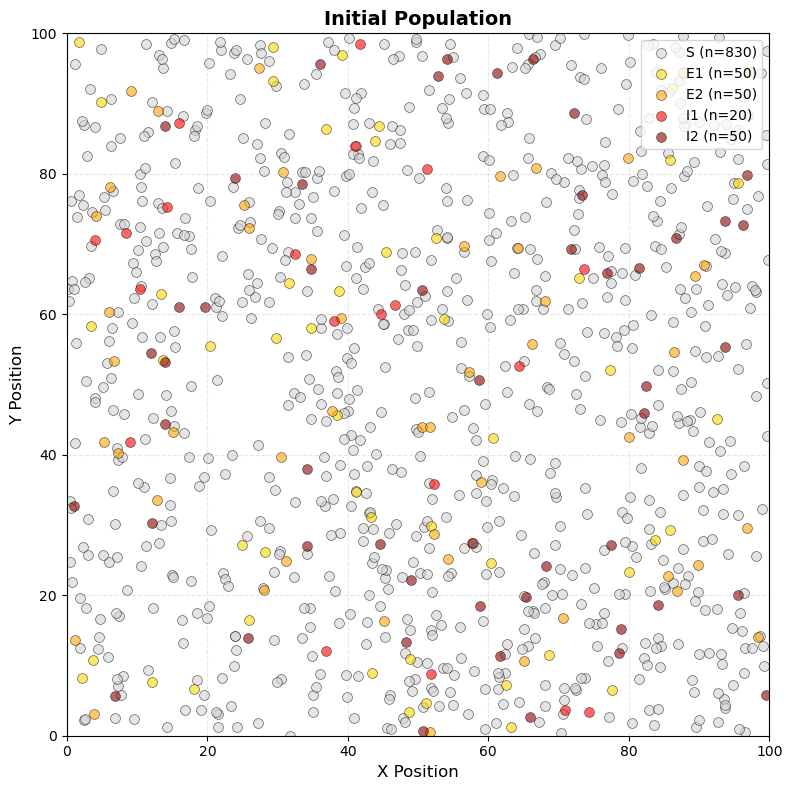

In [26]:
# Create population matching ODE initial conditions
population = initialize_population(
    n_agents=1000,
    space_size=100.0,
    initial_states={'S': 830, 'E1': 50, 'E2': 50, 'I1': 20, 'I2': 50},
    seed=42
)

print(f"Created population of {len(population)} agents")
print(f"First agent: {population[0]}")

# Build spatial index
spatial_index = SpatialIndex(space_size=100.0, cell_size=10.0)
spatial_index.update(population)

# Find neighbors for a random agent
query_agent = population[100]
neighbors = spatial_index.find_neighbors(query_agent, radius=5.0)

print(f"Query agent: {query_agent}")
print(f"Found {len(neighbors)} neighbors within radius 5.0")

# Visualize population
plot_population(population, space_size=100.0, title="Initial Population")

## Progress Disease States: State Transitions

In [27]:
#======================================
# Disease Dynamics - State Transitions
#======================================
def progress_disease_states(
    agents: List[Agent],
    latent_period: float = 2.0,
    latent_to_infectious: float = 2.0,
    infectious_period: float = 3.0,
    infectious_to_recovered: float = 3.0,
    recovered_period: float = 14.0,
    dt: float = 1.0
) -> None:
    """
    Progress agents through disease states based on time in current state.
    
    State progression chain:
        S (terminal) - no transitions
        E1 → (latent_period) → E2
        E2 → (latent_to_infectious) → I1
        I1 → (infectious_period) → I2
        I2 → (infectious_to_recovered) → R1
        R1 → (recovered_period) → R2
        R2 (terminal) - no transitions
    
    Parameters:
        agents: List of Agent objects to update (modified in-place)
        latent_period: Days for E1 → E2 transition
        latent_to_infectious: Days for E2 → I1 transition
        infectious_period: Days for I1 → I2 transition
        infectious_to_recovered: Days for I2 → R1 transition
        recovered_period: Days for R1 → R2 transition
        dt: Time step increment in days
    
    Raises:
        ValueError: If any timing parameter or dt is non-positive
    
    Notes:
        - Agents in 'S' or 'R2' states never transition
        - When transition occurs, time_in_state is reset to 0.0
        - All agents have dt added to their time_in_state
    """
    # Validation
    timing_params = {
        'latent_period': latent_period,
        'latent_to_infectious': latent_to_infectious,
        'infectious_period': infectious_period,
        'infectious_to_recovered': infectious_to_recovered,
        'recovered_period': recovered_period,
        'dt': dt
    }
    
    for param_name, param_value in timing_params.items():
        if param_value <= 0:
            raise ValueError(f"{param_name} must be positive. Got {param_value}")
    
    # State transition thresholds
    state_transitions = {
        'E1': ('E2', latent_period),
        'E2': ('I1', latent_to_infectious),
        'I1': ('I2', infectious_period),
        'I2': ('R1', infectious_to_recovered),
        'R1': ('R2', recovered_period)
    }
    
    # Update each agent
    for agent in agents:
        # Add time step
        agent.time_in_state += dt
        
        # Check for state transition (S and R2 are terminal, so not in dict)
        if agent.state in state_transitions:
            next_state, threshold = state_transitions[agent.state]
            
            # Transition if threshold reached
            if agent.time_in_state >= threshold:
                agent.state = next_state
                agent.time_in_state = 0.0

Initial: Agent #0 [E1] at (50.0, 50.0)
Day 2.0: Agent #0 [E2] at (50.0, 50.0)
Day 4.0: Agent #0 [I1] at (50.0, 50.0)
Day 6.0: Agent #0 [I1] at (50.0, 50.0)
Day 8.0: Agent #0 [I2] at (50.0, 50.0)
Day 10.0: Agent #0 [R1] at (50.0, 50.0)
Full Disease Progression (E1 → E2 → I1 → I2 → R1 → R2)
Day  0: State = E1, Time in state = 0.00
Day  2: State = E2, Time in state = 0.00
Day  4: State = I1, Time in state = 0.00
Day  7: State = I2, Time in state = 0.00
Day 10: State = R1, Time in state = 0.00
Day 24: State = R2, Time in state = 0.00

State transition summary:
  E1 → E2: 2 days
  E2 → I1: 2 days
  I1 → I2: 3 days
  I2 → R1: 3 days
  R1 → R2: 14 days
Population State Progression Over Time
Day  0: S=700 E1= 50 E2= 50 I1= 50 I2= 50 R1= 50 R2= 50 
Day  1: S=700 E1= 50 E2= 50 I1= 50 I2= 50 R1= 50 R2= 50 
Day  2: S=700 E1=  0 E2= 50 I1=100 I2= 50 R1= 50 R2= 50 
Day  3: S=700 E1=  0 E2= 50 I1= 50 I2= 50 R1=100 R2= 50 
Day  4: S=700 E1=  0 E2=  0 I1=100 I2= 50 R1=100 R2= 50 
Day  5: S=700 E1=  0 E

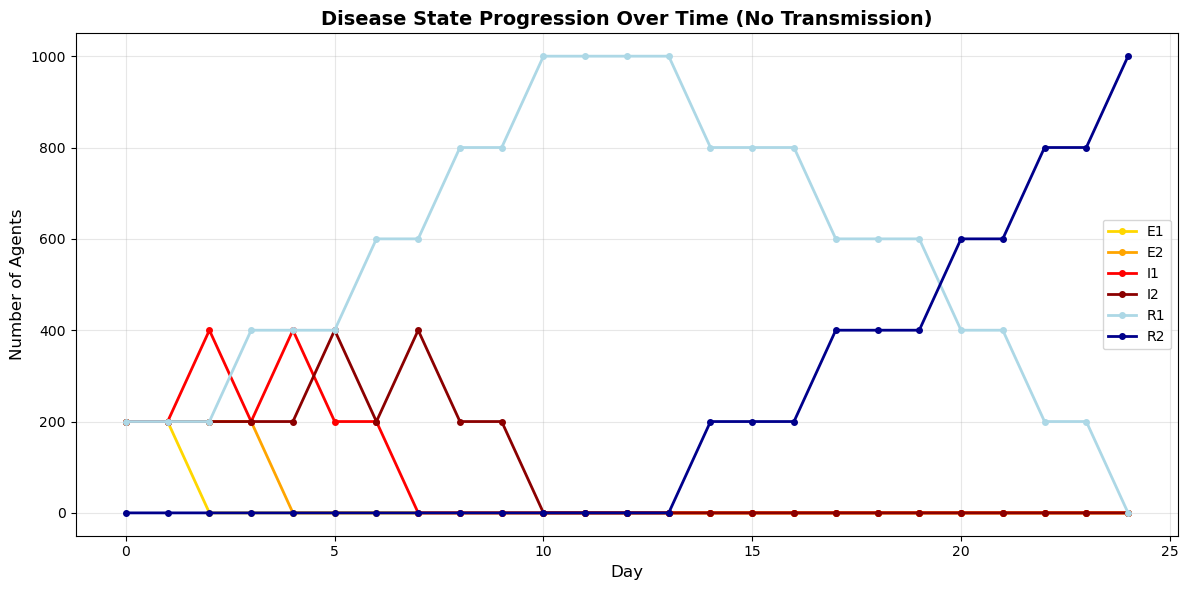

Final distribution after 24 days:
  E1:   0 agents
  E2:   0 agents
  I1:   0 agents
  I2:   0 agents
  R1:   0 agents
  R2: 1000 agents


In [28]:
# Example of disease state progression
# Create an agent in E1 state
agent = Agent(id=0, x=50.0, y=50.0, state='E1', time_in_state=0.0)
print(f"Initial: {agent}")

# Progress through 10 days with 0.5 day time steps
for day in range(20):  # 20 steps * 0.5 = 10 days
    progress_disease_states([agent], dt=0.5)
    if day % 4 == 3:  # Print every 2 days
        print(f"Day {(day + 1) * 0.5:.1f}: {agent}")


# Track complete progression from E1 to R2
agent = Agent(id=0, x=50.0, y=50.0, state='E1', time_in_state=0.0)

print("Full Disease Progression (E1 → E2 → I1 → I2 → R1 → R2)")
print("=" * 60)

states_observed = []
day = 0
max_days = 30

while agent.state != 'R2' and day < max_days:
    # Record state changes
    if not states_observed or states_observed[-1][1] != agent.state:
        states_observed.append((day, agent.state, agent.time_in_state))
        print(f"Day {day:2d}: State = {agent.state}, Time in state = {agent.time_in_state:.2f}")
    
    # Progress one day
    progress_disease_states([agent], dt=1.0)
    day += 1

# Final state
states_observed.append((day, agent.state, agent.time_in_state))
print(f"Day {day:2d}: State = {agent.state}, Time in state = {agent.time_in_state:.2f}")
print("\n" + "=" * 60)
print("State transition summary:")
for i, (d, s, t) in enumerate(states_observed):
    if i > 0:
        duration = d - states_observed[i-1][0]
        print(f"  {states_observed[i-1][1]} → {s}: {duration} days")


# Create population with mixed states
population = initialize_population(
    n_agents=1000,
    space_size=100.0,
    initial_states={
        'S': 700,
        'E1': 50,
        'E2': 50,
        'I1': 50,
        'I2': 50,
        'R1': 50,
        'R2': 50
    },
    seed=42
)

print("Population State Progression Over Time")
print("=" * 60)

# Track state counts over time
time_points = []
state_counts_over_time = []

for step in range(15):  # 15 days
    # Count states
    state_counts = {}
    for agent in population:
        state_counts[agent.state] = state_counts.get(agent.state, 0) + 1
    
    time_points.append(step)
    state_counts_over_time.append(state_counts)
    
    # Print summary
    print(f"Day {step:2d}: ", end="")
    for state in ['S', 'E1', 'E2', 'I1', 'I2', 'R1', 'R2']:
        count = state_counts.get(state, 0)
        print(f"{state}={count:3d} ", end="")
    print()
    
    # Progress all agents
    progress_disease_states(population, dt=1.0)

print("=" * 60)
print("Note: S agents never change, others progress through disease states")


# Run simulation
population = initialize_population(
    n_agents=1000,
    space_size=100.0,
    initial_states={
        'E1': 200,
        'E2': 200,
        'I1': 200,
        'I2': 200,
        'R1': 200
    },
    seed=42
)

# Track counts
days = []
state_data = {state: [] for state in ['E1', 'E2', 'I1', 'I2', 'R1', 'R2']}

for day in range(25):
    days.append(day)
    
    # Count current states
    for state in state_data.keys():
        count = sum(1 for agent in population if agent.state == state)
        state_data[state].append(count)
    
    # Progress
    progress_disease_states(population, dt=1.0)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

colors = {
    'E1': 'gold',
    'E2': 'orange',
    'I1': 'red',
    'I2': 'darkred',
    'R1': 'lightblue',
    'R2': 'darkblue'
}

for state in ['E1', 'E2', 'I1', 'I2', 'R1', 'R2']:
    ax.plot(days, state_data[state], label=state, color=colors[state], 
            linewidth=2, marker='o', markersize=4)

ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Number of Agents', fontsize=12)
ax.set_title('Disease State Progression Over Time (No Transmission)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='right', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final distribution after {days[-1]} days:")
for state in ['E1', 'E2', 'I1', 'I2', 'R1', 'R2']:
    count = sum(1 for agent in population if agent.state == state)
    print(f"  {state}: {count:3d} agents")



## Spatial Transmission 

In [29]:
#======================
# Spatial Transmission
#======================

def apply_transmission(
        agents: List[Agent],
        spatial_index: SpatialIndex,
        transmission_radius: float = 5.0,
        transmission_prob: float = 0.1,
        seed: int = None
) -> int:
    """
    Apply spatial transmission of disease between agents. 

    Only susceptible ("S") agents can be infected
    Only infectious ("I1" or "I2") agents can transmit
    Transmission occurs based on proximity and probability

    Parameters:
        agents: LIst of Agent objects to update (modified in-place)
        spatial_index: SpatialIndex for efficient neighbor finding
        transmission_radius: Maximum distance for transmission
        transmission_prob: Probability of infection per infectious contact
        seed: Random seed for reproducibility 
    
    Returns: 
        Number of new infections (int)
    
    Raises:
        ValueError if transmission radius <= 0
        ValueError if transmission_prob not in [0, 1]
        ValueError if seed is None 

    Notes: 
        Newly infected agents transition to "E1" with time_in_state == 0.0
        Each susceptible agent can only be infected once per call 
        Uses spatial_index for efficient neighbor queries
    """ 
    # validation
    if transmission_radius <= 0:
        raise ValueError(f"transmission_radius must be positive. Got {transmission_radius}")
    
    if transmission_prob < 0 or transmission_prob > 1:
        raise ValueError(f"transmission_prob must be in [0, 1]. Got {transmission_prob}")
    
    if seed is None:
        raise ValueError("seed must be provided for deterministic behavior")
    
    # Set random seed
    np.random.seed(seed)

    # track new infections
    new_infections = 0

    # find all susceptible and infectious agents
    susceptible_agents = [agent for agent in agents if agent.state == 'S']

    # process each susceptible agent
    for susceptible in susceptible_agents:
        # find a neighbor within transmission radius
        neighbors = spatial_index.find_neighbors(susceptible, transmission_radius)

        # fliter for infectious neighbors (I1, I2)
        infectious_neighbors = [n for n in neighbors if n.state in ['I1', 'I2']]

        # try infection from each infectious neighbor
        for infectious in infectious_neighbors:
            # roll for infection
            if np.random.random() < transmission_prob:
                # infect the susceptible agent
                susceptible.state = 'E1' 
                susceptible.time_in_state = 0.0 
                new_infections += 1 
                break # agent can only be infected once 
    return new_infections 

In [30]:
# Example spatial transmission mechanics
# Example 1: Guaranteed transmission with close proximity
print("Example 1: Guaranteed transmission (prob=1.0)")

agents = [
    Agent(id=0, x=0.0, y=0.0, state='S'),
    Agent(id=1, x=2.0, y=0.0, state='I2'),  #close neighbor
    Agent(id=2, x=10.0, y=0.0, state='I1')  #distant neighbor
]

spatial_index = SpatialIndex(space_size=100.0, cell_size=10.0)
spatial_index.update(agents)

print("Before transmission")
for agent in agents:
    print(f" {agent}")

new_infections = apply_transmission(
    agents, 
    spatial_index,
    transmission_radius=5.0,
    transmission_prob=1.0,
    seed=42
)

print(f"\nNew infections: {new_infections}")
print("\nAfter transmission:")
for agent in agents:
    print(f"  {agent}")

print("\n✓ Agent 0 infected by Agent 1 (within radius)")
print("✓ Agent 2 too far away (distance > radius)")


Example 1: Guaranteed transmission (prob=1.0)
Before transmission
 Agent #0 [S] at (0.0, 0.0)
 Agent #1 [I2] at (2.0, 0.0)
 Agent #2 [I1] at (10.0, 0.0)

New infections: 1

After transmission:
  Agent #0 [E1] at (0.0, 0.0)
  Agent #1 [I2] at (2.0, 0.0)
  Agent #2 [I1] at (10.0, 0.0)

✓ Agent 0 infected by Agent 1 (within radius)
✓ Agent 2 too far away (distance > radius)


In [31]:
# Example 2: Distance effects
print("Example 2: Distance Effects on Transmission")
print("=" * 60)

# Create agents at different distances from an infectious source
agents = [
    Agent(id=0, x=50.0, y=50.0, state='I1'),  # Infectious source
    Agent(id=1, x=51.0, y=50.0, state='S'),   # Distance = 1.0
    Agent(id=2, x=53.0, y=50.0, state='S'),   # Distance = 3.0
    Agent(id=3, x=55.0, y=50.0, state='S'),   # Distance = 5.0 (boundary)
    Agent(id=4, x=56.0, y=50.0, state='S'),   # Distance = 6.0 (too far)
]

spatial_index = SpatialIndex(space_size=100.0, cell_size=10.0)
spatial_index.update(agents)

print("Agent positions:")
for agent in agents:
    if agent.state == 'I1':
        print(f"  Agent {agent.id}: INFECTIOUS at ({agent.x}, {agent.y})")
    else:
        distance = agent.distance_to(agents[0])
        print(f"  Agent {agent.id}: Susceptible at distance {distance:.1f}")

new_infections = apply_transmission(
    agents,
    spatial_index,
    transmission_radius=5.0,
    transmission_prob=1.0,
    seed=42
)

print(f"\nWith transmission_radius=5.0:")
print(f"New infections: {new_infections}")
for i, agent in enumerate(agents):
    if i > 0:  # Skip the infectious agent
        print(f"  Agent {agent.id}: {agent.state}")

Example 2: Distance Effects on Transmission
Agent positions:
  Agent 0: INFECTIOUS at (50.0, 50.0)
  Agent 1: Susceptible at distance 1.0
  Agent 2: Susceptible at distance 3.0
  Agent 3: Susceptible at distance 5.0
  Agent 4: Susceptible at distance 6.0

With transmission_radius=5.0:
New infections: 3
  Agent 1: E1
  Agent 2: E1
  Agent 3: E1
  Agent 4: S


In [32]:
# Example 3: Probability effects
print("Example 3: Transmission Probability Effects")
print("=" * 60)

# Test different transmission probabilities
probabilities = [0.0, 0.25, 0.5, 0.75, 1.0]
results = []

for prob in probabilities:
    # Create fresh population for each test
    agents = [
        Agent(id=0, x=50.0, y=50.0, state='I1')
    ]
    # Add 100 susceptible agents nearby
    for i in range(100):
        agents.append(Agent(
            id=i+1,
            x=50.0 + np.random.uniform(-3, 3),
            y=50.0 + np.random.uniform(-3, 3),
            state='S'
        ))
    
    spatial_index = SpatialIndex(space_size=100.0, cell_size=10.0)
    spatial_index.update(agents)
    
    new_infections = apply_transmission(
        agents,
        spatial_index,
        transmission_radius=5.0,
        transmission_prob=prob,
        seed=42
    )
    
    results.append((prob, new_infections))
    print(f"Probability {prob:.2f}: {new_infections}/100 infected ({new_infections}%)")

print("\n✓ Higher probability → More infections")

Example 3: Transmission Probability Effects
Probability 0.00: 0/100 infected (0%)
Probability 0.25: 29/100 infected (29%)
Probability 0.50: 53/100 infected (53%)
Probability 0.75: 76/100 infected (76%)
Probability 1.00: 100/100 infected (100%)

✓ Higher probability → More infections


In [33]:
# Example 4: Population-level transmission dynamics
print("Example 4: Population Transmission Over Time")
print("=" * 60)

# Create population: mostly susceptible, few infectious
population = initialize_population(
    n_agents=500,
    space_size=100.0,
    initial_states={'S': 490, 'I1': 5, 'I2': 5},
    seed=42
)

spatial_index = SpatialIndex(space_size=100.0, cell_size=10.0)

# Run for 10 time steps (without disease progression)
print("Day | New Infections | S     | E1    | I1/I2")
print("-" * 60)

for step in range(10):
    # Count states before transmission
    state_counts = {}
    for agent in population:
        state_counts[agent.state] = state_counts.get(agent.state, 0) + 1
    
    # Update spatial index and apply transmission
    spatial_index.update(population)
    new_infections = apply_transmission(
        population,
        spatial_index,
        transmission_radius=5.0,
        transmission_prob=0.2,
        seed=42 + step  # Different seed each step
    )
    
    infectious_count = state_counts.get('I1', 0) + state_counts.get('I2', 0)
    
    print(f"{step:3d} | {new_infections:14d} | {state_counts.get('S', 0):5d} | "
          f"{state_counts.get('E1', 0):5d} | {infectious_count:5d}")

print("\n✓ New infections occur each step as susceptibles contact infectious agents")
print("✓ Note: Without disease progression, I1/I2 counts stay constant")


Example 4: Population Transmission Over Time
Day | New Infections | S     | E1    | I1/I2
------------------------------------------------------------
  0 |             14 |   490 |     0 |    10
  1 |              7 |   476 |    14 |    10
  2 |              3 |   469 |    21 |    10
  3 |              5 |   466 |    24 |    10
  4 |              3 |   461 |    29 |    10
  5 |              3 |   458 |    32 |    10
  6 |              1 |   455 |    35 |    10
  7 |              0 |   454 |    36 |    10
  8 |              0 |   454 |    36 |    10
  9 |              2 |   454 |    36 |    10

✓ New infections occur each step as susceptibles contact infectious agents
✓ Note: Without disease progression, I1/I2 counts stay constant


Example 5: Spatial Transmission Visualization
Created 91 agents (1 infectious, rest susceptible)


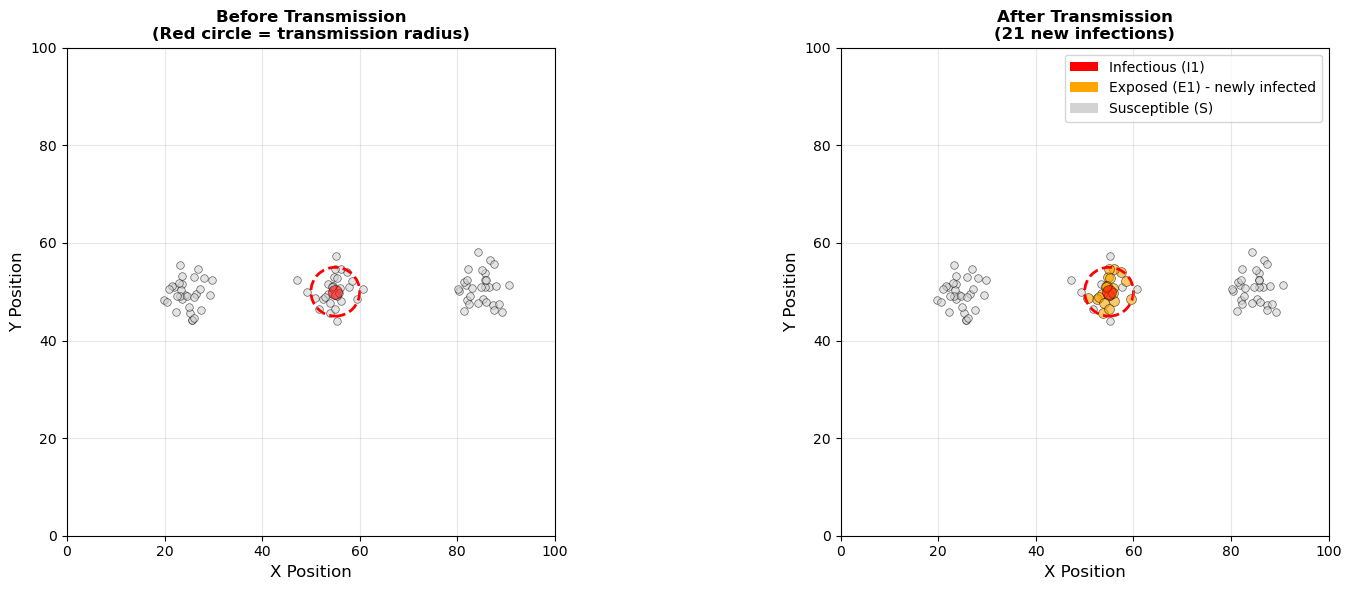


✓ 21 agents infected within transmission radius
✓ Orange dots show newly exposed agents


In [34]:
# Example 5: Visualize spatial transmission
print("Example 5: Spatial Transmission Visualization")
print("=" * 60)

# Create a clustered population
np.random.seed(42)
agents = []
agent_id = 0

# Create 3 clusters of susceptible agents
for cluster in range(3):
    center_x = 25.0 + cluster * 30.0
    center_y = 50.0
    
    for i in range(30):
        agents.append(Agent(
            id=agent_id,
            x=center_x + np.random.normal(0, 3),
            y=center_y + np.random.normal(0, 3),
            state='S'
        ))
        agent_id += 1

# Add one infectious agent in the middle cluster
agents.append(Agent(id=agent_id, x=55.0, y=50.0, state='I1'))

print(f"Created {len(agents)} agents (1 infectious, rest susceptible)")

# Visualize before transmission
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Before transmission
for agent in agents:
    color = 'red' if agent.state == 'I1' else 'lightgray'
    size = 100 if agent.state == 'I1' else 30
    ax1.scatter(agent.x, agent.y, c=color, s=size, alpha=0.6, edgecolors='black', linewidths=0.5)

# Draw transmission radius around infectious agent
infectious = [a for a in agents if a.state == 'I1'][0]
circle = plt.Circle((infectious.x, infectious.y), 5.0, color='red', fill=False, linestyle='--', linewidth=2)
ax1.add_patch(circle)

ax1.set_xlim(0, 100)
ax1.set_ylim(0, 100)
ax1.set_xlabel('X Position', fontsize=12)
ax1.set_ylabel('Y Position', fontsize=12)
ax1.set_title('Before Transmission\n(Red circle = transmission radius)', fontsize=12, fontweight='bold')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Apply transmission
spatial_index = SpatialIndex(space_size=100.0, cell_size=10.0)
spatial_index.update(agents)
new_infections = apply_transmission(
    agents,
    spatial_index,
    transmission_radius=5.0,
    transmission_prob=0.8,
    seed=42
)

# After transmission
for agent in agents:
    if agent.state == 'I1':
        color = 'red'
        size = 100
    elif agent.state == 'E1':
        color = 'orange'
        size = 50
    else:
        color = 'lightgray'
        size = 30
    ax2.scatter(agent.x, agent.y, c=color, s=size, alpha=0.6, edgecolors='black', linewidths=0.5)

circle2 = plt.Circle((infectious.x, infectious.y), 5.0, color='red', fill=False, linestyle='--', linewidth=2)
ax2.add_patch(circle2)

ax2.set_xlim(0, 100)
ax2.set_ylim(0, 100)
ax2.set_xlabel('X Position', fontsize=12)
ax2.set_ylabel('Y Position', fontsize=12)
ax2.set_title(f'After Transmission\n({new_infections} new infections)', fontsize=12, fontweight='bold')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='Infectious (I1)'),
    Patch(facecolor='orange', label='Exposed (E1) - newly infected'),
    Patch(facecolor='lightgray', label='Susceptible (S)')
]
ax2.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print(f"\n✓ {new_infections} agents infected within transmission radius")
print("✓ Orange dots show newly exposed agents")

## Simulation 

In [35]:
#============================
# Simulation 
#============================
def simulation_step(
        agents: List[Agent],
        spatial_index: SpatialIndex,
        dt: float,
        transmission_radius: float=5.0,
        transmission_prob: float=0.1,
        latent_period: float=2.0,
        latent_to_infectious: float=2.0,
        infectious_period: float=3.0,
        infectious_to_recovered: float=3.0,
        recovered_period: float=14.0,
        seed: int=None,
        current_time: float=0.0
) -> Dict:
    """
    Advance simulation by one time step, coordinating all model components 

    Execution order (CRITICAL):
        1) update spatial index with current positions
        2) apply transmission (S -> E1 infections)
        3) progress disease states (E1 -> E2 -> I1 -> I2 -> R1 -> R2)
        4) count states and return statistics

    Parameters:
        agents: List of Agent objects (nodified in-place)
        spatial_index: SpatialIndex for neighbor finding 
        dt: time step in days 
        transmission_radius: maximum distance for transmission 
        transmission_prob: probability of infection per contact 
        latent_period: days for E1 -> E2 transition 
        latent_to_infectious: days for E2 -> I1 transition
        infectious_period: days for I1 -> I2 transition 
        infectious_to_recovered: days for I2 -> R1 transition
        recovered_period: days for R1 -> R2 transition 
        seed: random seed for transmission (REQUIRED)
        current_time: current simulation time in days

    Returns:
        Dictionary containing: 
            'new_infections': number of new S -> E1 transitions (int)
            'state_counts': Dict mapping state -> count 
            'time': updated simulation time (current_time + dt) 
    
    Raises:
        ValueError: if dt <= 0
        ValueError: if seed is None 
    
    NOtes: 
        Transmission occurs BEFORE disease progression - ensuring newly infected 
            agents don't immediately progress 
        All timing parameters passed to underlying functions 
    """

    # validation 
    if dt <= 0:
        raise ValueError(f"dt must be positive. Got {dt}")
    
    if seed is None:
        raise ValueError("seed must be provided for deterministic behavior")
    
    # step 1: Update spatial index with current agent positions
    spatial_index.update(agents) 

    # step 2: Apply transmission (S -> E1) 
    new_infections = apply_transmission(
        agents=agents,
        spatial_index=spatial_index,
        transmission_radius=transmission_radius,
        transmission_prob=transmission_prob,
        seed=seed
    )

    # step 3: Progress disease states (E1 -> E2 -> I1 -> I2 -> R1 -> R2)
    progress_disease_states(
        agents=agents,
        latent_period=latent_period,
        latent_to_infectious=latent_to_infectious,
        infectious_period=infectious_period,
        infectious_to_recovered=infectious_to_recovered,
        recovered_period=recovered_period,
        dt=dt
    )

    # step 4: Count states and prepare statistics 
    state_counts = {} 
    for agent in agents:
        state_counts[agent.state] = state_counts.get(agent.state, 0) + 1 

    # update time
    new_time = current_time + dt 

    # return statistics 
    return {
        'new_infections': new_infections,
        'state_counts': state_counts,
        'time': new_time
    }

In [36]:
# Complete simulation example 
print("Example 1: Simple Outbreak Simulation")
print("=" * 60)

# Create population
population = initialize_population(
    n_agents=200,
    space_size=50.0,
    initial_states={'S': 195, 'I1': 5},
    seed=42
)

spatial_index = SpatialIndex(space_size=50.0, cell_size=10.0)

# Run simulation for 20 days
print("Day | New Inf | S     | E1    | E2    | I1    | I2    | R1    | R2")
print("-" * 75)

current_time = 0.0
for step in range(20):
    stats = simulation_step(
        agents=population,
        spatial_index=spatial_index,
        dt=1.0,
        transmission_radius=5.0,
        transmission_prob=0.15,
        seed=42 + step,
        current_time=current_time
    )
    
    current_time = stats['time']
    
    # Print summary
    counts = stats['state_counts']
    print(f"{int(current_time):3d} | {stats['new_infections']:7d} | "
          f"{counts.get('S', 0):5d} | {counts.get('E1', 0):5d} | "
          f"{counts.get('E2', 0):5d} | {counts.get('I1', 0):5d} | "
          f"{counts.get('I2', 0):5d} | {counts.get('R1', 0):5d} | "
          f"{counts.get('R2', 0):5d}")

print("\n✓ Complete epidemic cycle visible!")
print("✓ S decreases, infections spread, eventually recoveries dominate")


Example 1: Simple Outbreak Simulation
Day | New Inf | S     | E1    | E2    | I1    | I2    | R1    | R2
---------------------------------------------------------------------------
  1 |       3 |   192 |     3 |     0 |     5 |     0 |     0 |     0
  2 |       5 |   187 |     5 |     3 |     5 |     0 |     0 |     0
  3 |       2 |   185 |     2 |     8 |     0 |     5 |     0 |     0
  4 |       3 |   182 |     3 |     7 |     3 |     5 |     0 |     0
  5 |       2 |   180 |     2 |     5 |     8 |     5 |     0 |     0
  6 |       5 |   175 |     5 |     5 |    10 |     0 |     5 |     0
  7 |       3 |   172 |     3 |     7 |    10 |     3 |     5 |     0
  8 |       1 |   171 |     1 |     8 |     7 |     8 |     5 |     0
  9 |       1 |   170 |     1 |     4 |    10 |    10 |     5 |     0
 10 |       4 |   166 |     4 |     2 |    10 |    10 |     8 |     0
 11 |       5 |   161 |     5 |     5 |     9 |     7 |    13 |     0
 12 |       2 |   159 |     2 |     9 |     5 |  

Example 2: Epidemic Curves Visualization


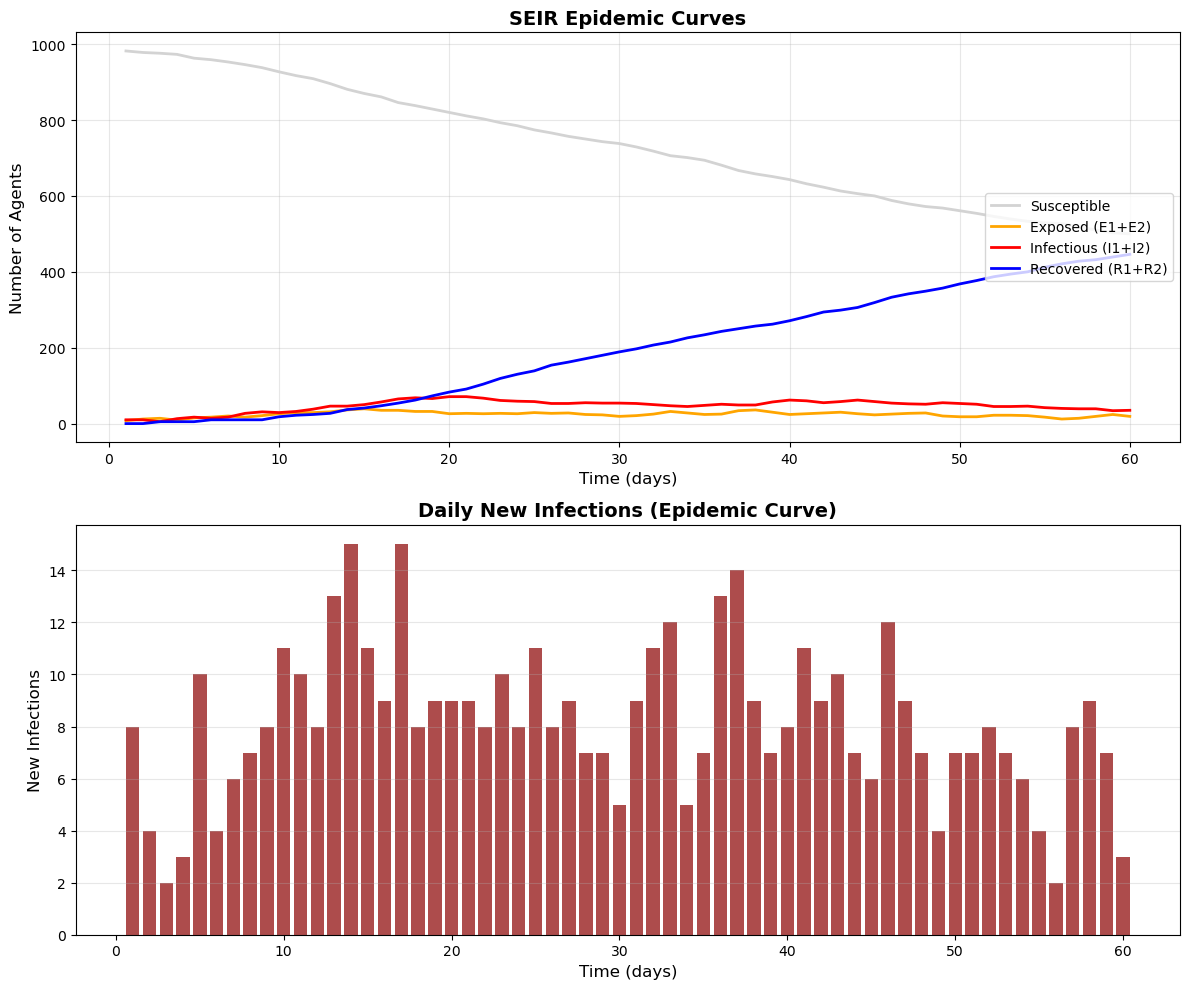


Epidemic Summary:
  Total infected: 500/1000 (50.0%)
  Peak infectious: 71 agents on day 20
  Final state: S=500, R=446


In [37]:
# Example 2: Track epidemic curves
print("Example 2: Epidemic Curves Visualization")
print("=" * 60)

# Create larger population
population = initialize_population(
    n_agents=1000,
    space_size=100.0,
    initial_states={'S': 990, 'I1': 5, 'I2': 5},
    seed=42
)

spatial_index = SpatialIndex(space_size=100.0, cell_size=10.0)

# Track data over time
history = {
    'time': [],
    'S': [], 'E1': [], 'E2': [],
    'I1': [], 'I2': [], 'R1': [], 'R2': [],
    'new_infections': []
}

current_time = 0.0
for step in range(60):
    stats = simulation_step(
        agents=population,
        spatial_index=spatial_index,
        dt=1.0,
        transmission_radius=5.0,
        transmission_prob=0.08,
        seed=42 + step,
        current_time=current_time
    )
    
    current_time = stats['time']
    
    # Record data
    history['time'].append(current_time)
    history['new_infections'].append(stats['new_infections'])
    
    for state in ['S', 'E1', 'E2', 'I1', 'I2', 'R1', 'R2']:
        history[state].append(stats['state_counts'].get(state, 0))

# Plot epidemic curves
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: SEIR compartments
ax1.plot(history['time'], history['S'], label='Susceptible', color='lightgray', linewidth=2)
ax1.plot(history['time'], [e1 + e2 for e1, e2 in zip(history['E1'], history['E2'])], 
         label='Exposed (E1+E2)', color='orange', linewidth=2)
ax1.plot(history['time'], [i1 + i2 for i1, i2 in zip(history['I1'], history['I2'])], 
         label='Infectious (I1+I2)', color='red', linewidth=2)
ax1.plot(history['time'], [r1 + r2 for r1, r2 in zip(history['R1'], history['R2'])], 
         label='Recovered (R1+R2)', color='blue', linewidth=2)

ax1.set_xlabel('Time (days)', fontsize=12)
ax1.set_ylabel('Number of Agents', fontsize=12)
ax1.set_title('SEIR Epidemic Curves', fontsize=14, fontweight='bold')
ax1.legend(loc='right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: New infections per day
ax2.bar(history['time'], history['new_infections'], color='darkred', alpha=0.7, width=0.8)
ax2.set_xlabel('Time (days)', fontsize=12)
ax2.set_ylabel('New Infections', fontsize=12)
ax2.set_title('Daily New Infections (Epidemic Curve)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
total_infected = 1000 - history['S'][-1]
peak_infectious = max([i1 + i2 for i1, i2 in zip(history['I1'], history['I2'])])
peak_day = history['time'][[i1 + i2 for i1, i2 in zip(history['I1'], history['I2'])].index(peak_infectious)]

print(f"\nEpidemic Summary:")
print(f"  Total infected: {total_infected}/1000 ({total_infected/10:.1f}%)")
print(f"  Peak infectious: {peak_infectious} agents on day {int(peak_day)}")
print(f"  Final state: S={history['S'][-1]}, R={history['R1'][-1] + history['R2'][-1]}")

Example 3: Comparing Transmission Probabilities

Running simulation with transmission_prob = 0.05...
  Final attack rate: 107/500 (21.4%)

Running simulation with transmission_prob = 0.10...
  Final attack rate: 185/500 (37.0%)

Running simulation with transmission_prob = 0.15...
  Final attack rate: 230/500 (46.0%)

Running simulation with transmission_prob = 0.20...
  Final attack rate: 312/500 (62.4%)


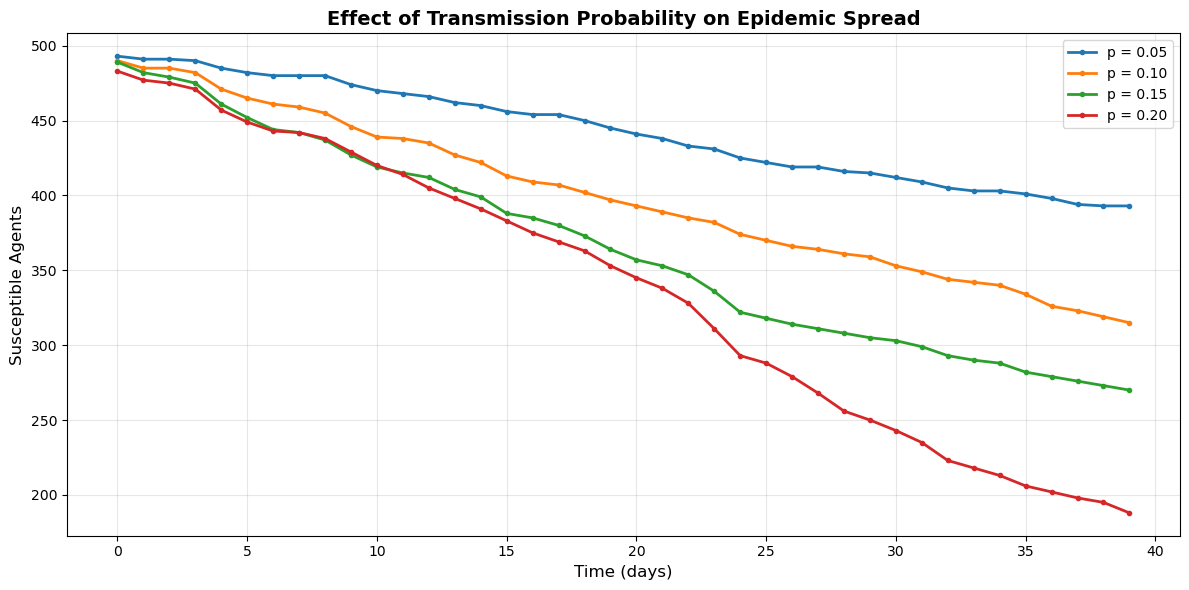


✓ Higher transmission probability → Faster, larger outbreaks


In [38]:
# Example 3: Parameter comparison
print("Example 3: Comparing Transmission Probabilities")
print("=" * 60)

transmission_probs = [0.05, 0.10, 0.15, 0.20]
results = {}

for prob in transmission_probs:
    print(f"\nRunning simulation with transmission_prob = {prob:.2f}...")
    
    # Create fresh population
    population = initialize_population(
        n_agents=500,
        space_size=75.0,
        initial_states={'S': 495, 'I1': 5},
        seed=42
    )
    
    spatial_index = SpatialIndex(space_size=75.0, cell_size=10.0)
    
    # Track susceptibles over time
    s_counts = []
    current_time = 0.0
    
    for step in range(40):
        stats = simulation_step(
            agents=population,
            spatial_index=spatial_index,
            dt=1.0,
            transmission_radius=5.0,
            transmission_prob=prob,
            seed=42 + step,
            current_time=current_time
        )
        current_time = stats['time']
        s_counts.append(stats['state_counts'].get('S', 0))
    
    results[prob] = s_counts
    final_infected = 500 - s_counts[-1]
    print(f"  Final attack rate: {final_infected}/500 ({final_infected/5:.1f}%)")

# Plot comparison
plt.figure(figsize=(12, 6))

for prob, s_counts in results.items():
    plt.plot(range(len(s_counts)), s_counts, label=f'p = {prob:.2f}', linewidth=2, marker='o', markersize=3)

plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Susceptible Agents', fontsize=12)
plt.title('Effect of Transmission Probability on Epidemic Spread', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Higher transmission probability → Faster, larger outbreaks")

Example 4: Spatial Spread Visualization


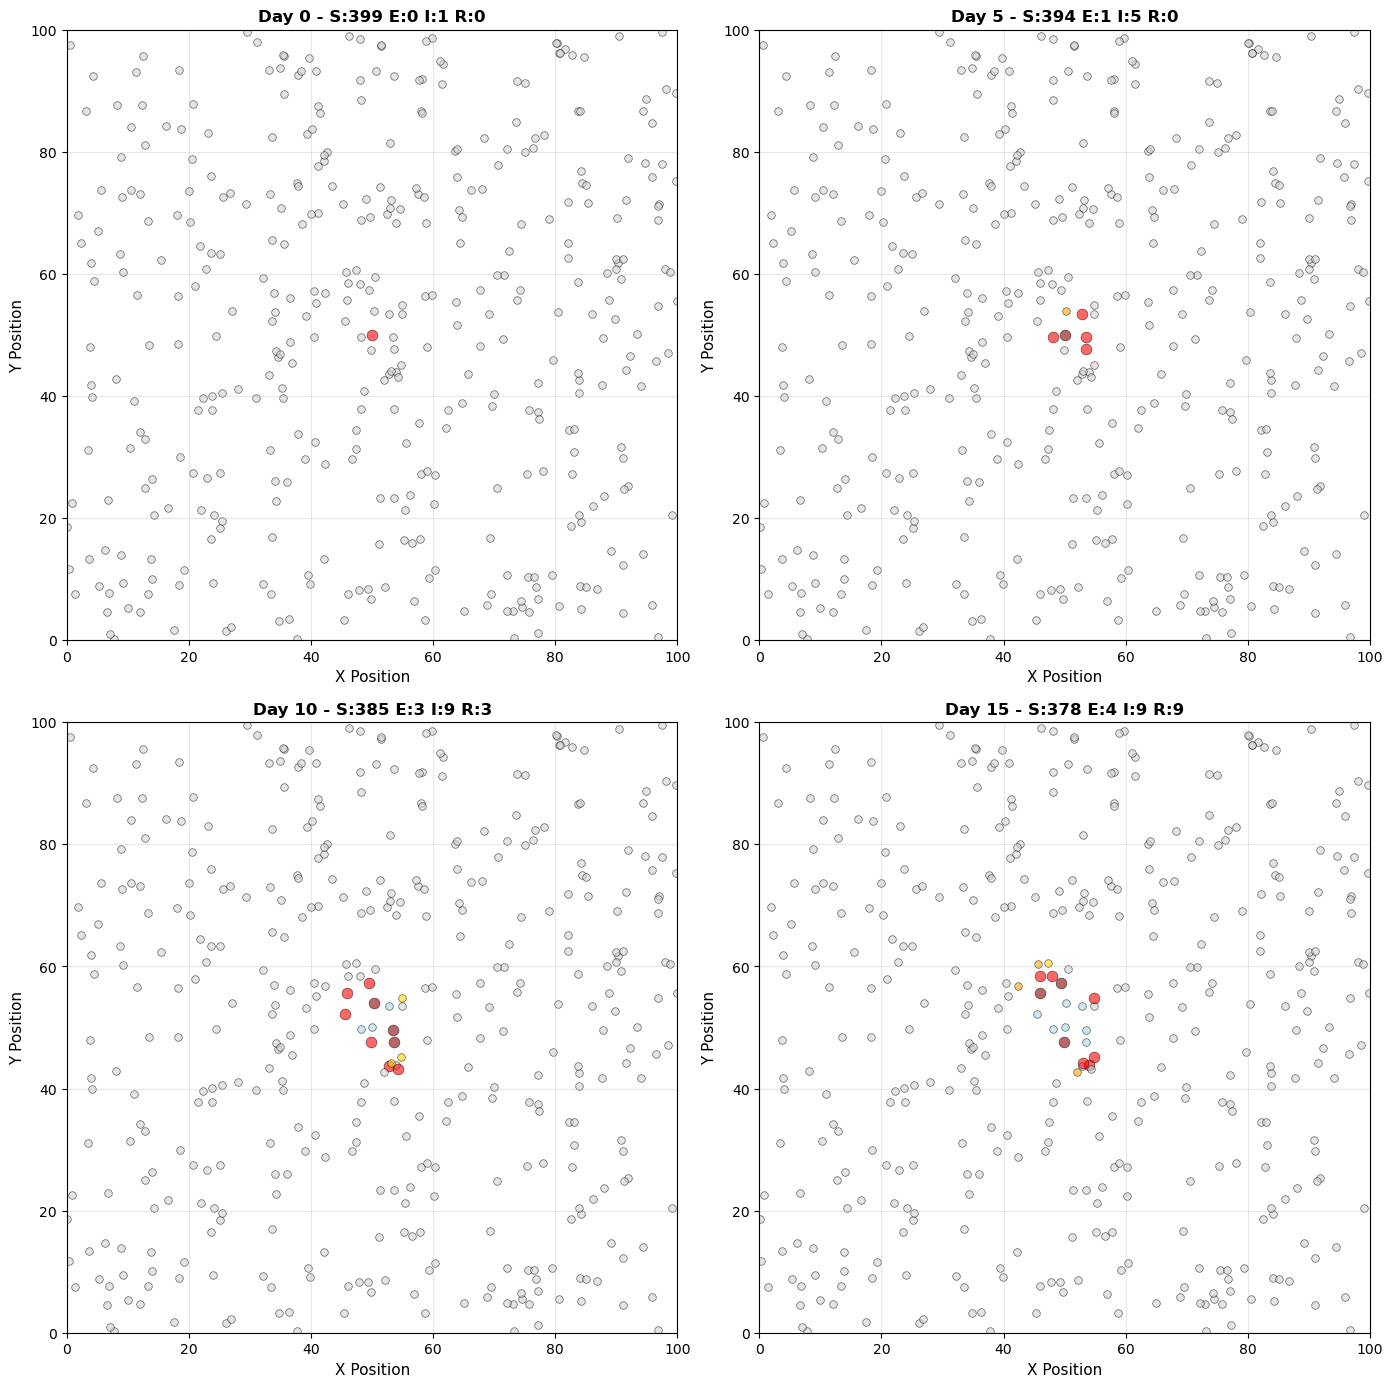

✓ Spatial spread from center outward over time
✓ Gray→Orange→Red→Blue color progression visible


In [39]:
# Example 4: Spatial dynamics over time
print("Example 4: Spatial Spread Visualization")
print("=" * 60)

# Create population with one infectious agent in center
population = initialize_population(
    n_agents=400,
    space_size=100.0,
    initial_states={'S': 399, 'I1': 1},
    seed=42
)

# Move the infectious agent to center
for agent in population:
    if agent.state == 'I1':
        agent.x = 50.0
        agent.y = 50.0
        break

spatial_index = SpatialIndex(space_size=100.0, cell_size=10.0)

# Create snapshots at different time points
snapshots = []
snapshot_times = [0, 5, 10, 15]
current_time = 0.0
step = 0

while current_time <= snapshot_times[-1]:
    if int(current_time) in snapshot_times:
        # Save snapshot
        snapshot = {
            'time': current_time,
            'agents': [(a.x, a.y, a.state) for a in population]
        }
        snapshots.append(snapshot)
    
    # Advance simulation
    stats = simulation_step(
        agents=population,
        spatial_index=spatial_index,
        dt=1.0,
        transmission_radius=5.0,
        transmission_prob=0.2,
        seed=42 + step,
        current_time=current_time
    )
    
    current_time = stats['time']
    step += 1

# Plot snapshots
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

state_colors = {
    'S': 'lightgray',
    'E1': 'gold',
    'E2': 'orange',
    'I1': 'red',
    'I2': 'darkred',
    'R1': 'lightblue',
    'R2': 'darkblue'
}

for idx, snapshot in enumerate(snapshots):
    ax = axes[idx]
    
    # Count states
    state_counts = {}
    for x, y, state in snapshot['agents']:
        state_counts[state] = state_counts.get(state, 0) + 1
        color = state_colors[state]
        size = 60 if state in ['I1', 'I2'] else 30
        ax.scatter(x, y, c=color, s=size, alpha=0.6, edgecolors='black', linewidths=0.5)
    
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_xlabel('X Position', fontsize=11)
    ax.set_ylabel('Y Position', fontsize=11)
    ax.set_title(f'Day {int(snapshot["time"])} - ' +
                 f'S:{state_counts.get("S", 0)} ' +
                 f'E:{state_counts.get("E1", 0) + state_counts.get("E2", 0)} ' +
                 f'I:{state_counts.get("I1", 0) + state_counts.get("I2", 0)} ' +
                 f'R:{state_counts.get("R1", 0) + state_counts.get("R2", 0)}',
                 fontsize=12, fontweight='bold')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Spatial spread from center outward over time")
print("✓ Gray→Orange→Red→Blue color progression visible")

Example 5: Comprehensive Statistics Tracking

Key Simulation Milestones:
------------------------------------------------------------
First transmission: Day 3
Peak infectious: 56 agents on day 17
Peak daily infections: 14 on day 5

Final State (Day 50):
  Susceptible: 175 (35.0%)
  Ever infected: 325 (65.0%)
  Currently infectious: 21
  Recovered: 290 (58.0%)


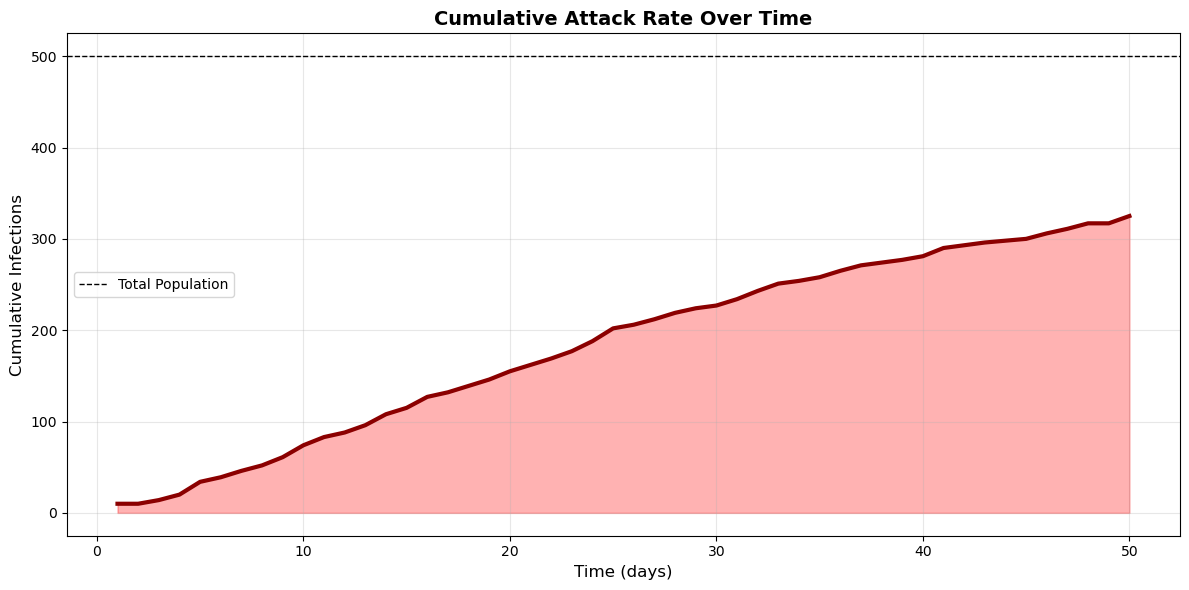

In [40]:
# Example 5: Detailed statistics tracking
print("Example 5: Comprehensive Statistics Tracking")
print("=" * 60)

# Create population
population = initialize_population(
    n_agents=500,
    space_size=75.0,
    initial_states={'S': 490, 'E1': 5, 'E2': 5},
    seed=42
)

spatial_index = SpatialIndex(space_size=75.0, cell_size=10.0)

# Track detailed statistics
stats_history = []
current_time = 0.0

for step in range(50):
    stats = simulation_step(
        agents=population,
        spatial_index=spatial_index,
        dt=1.0,
        transmission_radius=5.0,
        transmission_prob=0.12,
        seed=42 + step,
        current_time=current_time
    )
    
    current_time = stats['time']
    
    # Add derived statistics
    stats['total_exposed'] = stats['state_counts'].get('E1', 0) + stats['state_counts'].get('E2', 0)
    stats['total_infectious'] = stats['state_counts'].get('I1', 0) + stats['state_counts'].get('I2', 0)
    stats['total_recovered'] = stats['state_counts'].get('R1', 0) + stats['state_counts'].get('R2', 0)
    stats['cumulative_infections'] = 500 - stats['state_counts'].get('S', 0)
    
    stats_history.append(stats)

# Display key time points
print("\nKey Simulation Milestones:")
print("-" * 60)

# First infection
first_infection_day = next((s['time'] for s in stats_history if s['new_infections'] > 0), None)
print(f"First transmission: Day {int(first_infection_day)}")

# Peak infectious
peak_infectious = max(s['total_infectious'] for s in stats_history)
peak_day = next(s['time'] for s in stats_history if s['total_infectious'] == peak_infectious)
print(f"Peak infectious: {peak_infectious} agents on day {int(peak_day)}")

# Maximum daily infections
max_daily_infections = max(s['new_infections'] for s in stats_history)
max_daily_day = next(s['time'] for s in stats_history if s['new_infections'] == max_daily_infections)
print(f"Peak daily infections: {max_daily_infections} on day {int(max_daily_day)}")

# Final statistics
final_stats = stats_history[-1]
print(f"\nFinal State (Day {int(final_stats['time'])}):")
print(f"  Susceptible: {final_stats['state_counts'].get('S', 0)} ({final_stats['state_counts'].get('S', 0)/5:.1f}%)")
print(f"  Ever infected: {final_stats['cumulative_infections']} ({final_stats['cumulative_infections']/5:.1f}%)")
print(f"  Currently infectious: {final_stats['total_infectious']}")
print(f"  Recovered: {final_stats['total_recovered']} ({final_stats['total_recovered']/5:.1f}%)")

# Plot cumulative infections
plt.figure(figsize=(12, 6))
cumulative_infections = [s['cumulative_infections'] for s in stats_history]
times = [s['time'] for s in stats_history]

plt.plot(times, cumulative_infections, linewidth=3, color='darkred')
plt.fill_between(times, 0, cumulative_infections, alpha=0.3, color='red')
plt.axhline(y=500, color='black', linestyle='--', linewidth=1, label='Total Population')
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Cumulative Infections', fontsize=12)
plt.title('Cumulative Attack Rate Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()